# Imports

In [3]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [4]:
%config InlineBackend.figure_format = 'svg'

from datetime import datetime
import deepinv as dinv
from functools import partial
import gc
from pathlib import Path
from time import time
import math

import numpy as np
import pandas as pd
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import dct, idct
from scipy.stats import entropy
import seaborn as sns
from tqdm import tqdm, trange
import yaml

from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, spectral_methods_wrapper, plot_error_bars, generate_signal
from deepinv.models.complex import to_complex_denoiser
from deepinv.physics.phase_retrieval import StructuredRandomPhaseRetrieval
from deepinv.physics.structured_random import MarchenkoPastur, padding, trimming

/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32491 MiB free memory 


device(type='cuda', index=0)

# Time complexity

In [5]:
# img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]
img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
print(img_sizes)
n_repeats = 100
oversampling = 1

[8, 16, 32, 64, 96, 128, 160, 192, 224, 240]


In [6]:
device = torch.device("cuda",index=0)
device

device(type='cuda', index=0)

In [7]:
torch.cuda.empty_cache()

In [6]:
# works well if not in class
foo = torch.randn((240**2, 240**2), device=device, dtype=torch.complex64)
bar = foo

In [6]:
physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*240**2),
            img_shape= (1, 240, 240),
            dtype = torch.complex64,
            device=device,
            test=True,
        )

In [7]:
physics.release_memory()

allocated memory: 0


In [ ]:
# random model

df_random_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    torch.cuda.empty_cache()
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)
    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.complex64,
            device=device,
            test=True,
        )
        torch.cuda.synchronize()
        init_time = time()
        y = physics.forward(x_phase)
        torch.cuda.synchronize()
        df_random_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        physics.release_memory()
        torch.cuda.empty_cache()
        print("allocated memory after clearing cache", torch.cuda.memory_allocated(device)/1024**2,"MB")

In [7]:
df_random_gpu.to_csv("df_random_gpu.csv", index=False)
df_random_gpu

,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,0.451463,0.000501,0.000638,0.00054,0.001046,0.003431,0.007872,0.016202,0.029026,0.031205
1,0.000252,0.000467,0.000466,0.000386,0.0012,0.00333,0.007773,0.016022,0.023464,0.031089
2,0.000179,0.00046,0.000462,0.000367,0.001196,0.003243,0.007803,0.016826,0.02349,0.031042
3,0.00017,0.000459,0.000453,0.000364,0.001208,0.003246,0.00778,0.016126,0.023477,0.03113
4,0.000168,0.000459,0.000451,0.000364,0.001168,0.003349,0.007809,0.015985,0.023582,0.031191
...,...,...,...,...,...,...,...,...,...,...
95,0.000164,0.000173,0.000174,0.000299,0.001241,0.003373,0.007748,0.016134,0.023584,0.031102
96,0.000164,0.000172,0.00017,0.000296,0.001233,0.0034,0.007826,0.016018,0.023588,0.030983
97,0.000164,0.000172,0.000168,0.000296,0.00123,0.003401,0.00777,0.016045,0.023482,0.031095
98,0.000165,0.000174,0.000168,0.000297,0.001246,0.003392,0.007826,0.015952,0.023474,0.031016


In [10]:
# structured model
df_structured_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.complex64,
            device=device,
        )
        init_time = time()
        torch.cuda.synchronize()
        y = physics.forward(x_phase)
        df_structured_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        torch.cuda.synchronize()
        physics.release_memory()
        torch.cuda.synchronize()

100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


In [12]:
df_structured_gpu.to_csv("paper/data/time/df_structured_gpu.csv", index=False)
df_structured_gpu

,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,0.000622,0.0006,0.000474,0.000599,0.000604,0.000614,0.000616,0.000591,0.000397,0.000668
1,0.000585,0.000626,0.000453,0.000578,0.000588,0.000577,0.000574,0.000545,0.000395,0.000636
2,0.000584,0.000567,0.000442,0.000568,0.000572,0.00057,0.000571,0.000577,0.000364,0.000632
3,0.000579,0.000568,0.000445,0.000576,0.000567,0.000571,0.000571,0.000528,0.000362,0.000626
4,0.000577,0.000563,0.000445,0.000562,0.000567,0.000567,0.000566,0.000531,0.00036,0.000572
...,...,...,...,...,...,...,...,...,...,...
95,0.0002,0.000224,0.000229,0.00023,0.000227,0.000202,0.000216,0.000222,0.000228,0.000211
96,0.000199,0.000221,0.000228,0.000222,0.000212,0.000201,0.000217,0.000209,0.000223,0.000211
97,0.000201,0.000222,0.00025,0.000223,0.000212,0.000196,0.000218,0.000206,0.000223,0.000221
98,0.0002,0.000221,0.000222,0.000222,0.000213,0.000197,0.000217,0.000216,0.000222,0.000205


In [13]:
device = 'cpu'

In [26]:
# random model
df_random_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.complex64,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_random_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

 80%|████████  | 8/10 [1:07:40<35:48, 1074.12s/it]

In [16]:
# structured model
df_structured_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.complex64,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_structured_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


In [17]:
df_structured_cpu.to_csv("paper/data/time/df_structured_cpu.csv", index=False)
df_structured_cpu.mean(axis=0)

img_size_8      0.000192
img_size_16     0.000185
img_size_32     0.000223
img_size_64     0.000314
img_size_96     0.000435
img_size_128    0.000539
img_size_160    0.000769
img_size_192    0.002995
img_size_224    0.003131
img_size_240    0.003242
dtype: object

In [15]:
pixels = [i**2 for i in img_sizes]

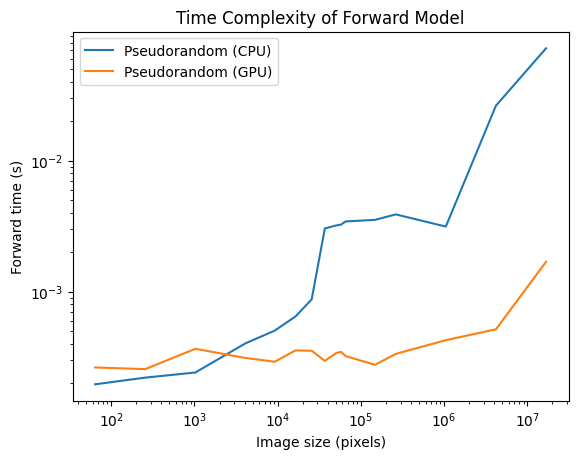

In [22]:
# plt.plot(pixels,df_random_cpu.mean(axis=0),label='Random (CPU)')
# plt.plot(pixels,df_random_gpu.mean(axis=0),label='Random (GPU)')
plt.plot(pixels,df_structured_cpu.mean(axis=0),label='structured (CPU)')
plt.plot(pixels,df_structured_gpu.mean(axis=0),label='structured (GPU)')
plt.xlabel('Image size (pixels)')
plt.ylabel('Forward time (s)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Time Complexity of Forward Model')
plt.legend()
plt.savefig('time.svg')
plt.show()

In [127]:
# save data
df_random_cpu.to_csv('df_random_cpu.csv')
df_random_gpu.to_csv('df_random_gpu.csv')
df_structured_cpu.to_csv('df_structured_cpu.csv')
df_structured_gpu.to_csv('df_structured_gpu.csv')

In [ ]:
plot_error_bars([pixels] * 4,
                [df_random_cpu, df_random_gpu, df_structured_cpu, df_structured_gpu],
                ['Random (CPU)', 'Random (GPU)', 'structured (CPU)', 'structured (GPU)'],
                title = f'Forward time (s) vs Image size (oversampling={oversampling})',
                xlabel = 'Image size',
                xscale = 'log',
                ylabel = 'Forward time (s)',
                yscale = 'log',
                axis = 0)

# Test playground for images

## Empirical Entropy of Images with Different Noise Levels

In [3]:
def empirical_entropy(data, bins):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)  # Histogram with density=True normalizes the data
    p = hist / hist.sum()  # Convert histogram counts to probabilities
    return entropy(p, base=2)  # Compute Shannon entropy

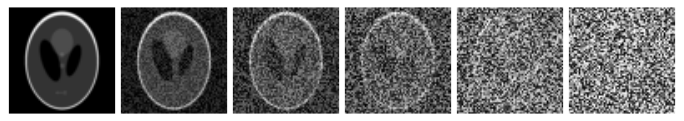

entropy: 1.7309282735617912 variance: 0.30625167
entropy: 2.342144353218072 variance: 0.22861837
entropy: 2.6301043570251794 variance: 0.23679414
entropy: 2.8930370001486554 variance: 0.34736353
entropy: 3.1746000357115185 variance: 0.5284606
entropy: 3.3205295637251497 variance: 0.81616026


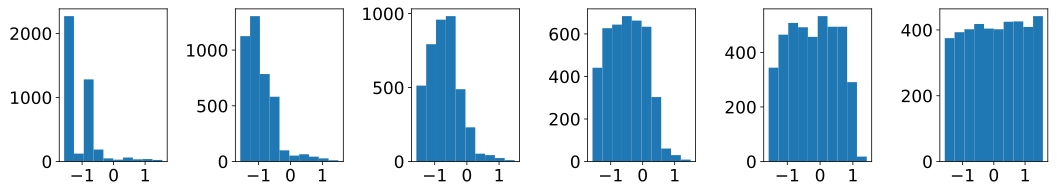

In [6]:
config = DotMap()
config.img_size = 64
config.mode = 'shepp-logan'
config.noise_ratio = 0.4
config.varying_norm = False
config.unit_mag = True

imgs = []
for i in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    config.noise_ratio = i
    x = generate_signal(
        config.img_size,
        config.mode,
        transform='noise',
        config=config,
        dtype=torch.complex64
    )
    imgs.append(x.angle())
plot(imgs)

# Create a figure with 1 row and 5 columns of subplots
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

# Iterate over the axes to plot on each subplot
for i, ax in enumerate(axes):
    ax.hist(imgs[i].flatten(), bins=10)  # Example plot
    H = empirical_entropy(imgs[i], bins=10)
    print("entropy:", H, "variance:", imgs[i].var().numpy())

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

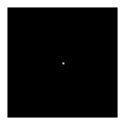

In [29]:
x = generate_signal(
    shape = (1, 64, 64),
    mode = ['delta','constant'],
)

plot(x.abs())

# i.i.d. random model

In [27]:
input_size = 64
output_size = 48

oversampling = 3.0

physics = dinv.physics.RandomPhaseRetrieval(
    m=output_size**2,
    img_shape=(1, input_size, input_size),
    product=1,
    dtype=torch.complex64,
    device=device,
)

In [28]:
physics.B._A.shape

torch.Size([2304, 4096])

In [29]:
spectrum = torch.linalg.svdvals(physics.B._A)
spectrum = spectrum[torch.randperm(spectrum.numel())]
spectrum.shape

torch.Size([2304])

# Diagonal

In [ ]:
diagonal = dinv.physics.phase_retrieval.generate_diagonal((1, 64*9, 64*9), mode=['marchenko','uniform'], dtype=torch.complex64, config={'m': 90**2,'n':64**2})

print((diagonal**2).mean()**2 + (diagonal**2).var())
print(diagonal)

#plt.hist(diagonal.angle().flatten().cpu(), bins=100);
#plt.hist((diagonal).angle().flatten().cpu(), bins=100);
plt.hist((diagonal**2).abs().flatten().cpu(), bins=20);

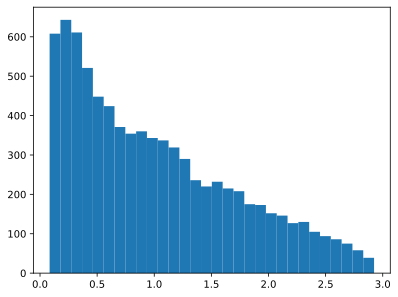

In [42]:
plt.hist(samples.flatten(), bins=30);

In [ ]:
semicircle = dinv.physics.phase_retrieval.SemiCircle(radius=0.6)

np.max(semicircle.pdf(np.linspace(semicircle.min_supp,semicircle.max_supp,10000)));
semicircle.pdf(1.0)
semicircle.pdf(semicircle.min_supp)
semicircle.pdf(semicircle.max_supp)

0.0

# Nelder-Mead Method to Optimize Spectrum

In [103]:
def find_specturm_frequencies(input_shape,output_shape, n_bins=20, n_samples=100000):
    # given an oversampling ratio, get the histgram of the marchenko pastur distribution by sampling.
    # return the edges of the bins and the frequencies normalized to sum to 1
    distribution = MarchenkoPastur(m=np.prod(output_shape), n=np.prod(input_shape))
    samples = distribution.sample(n_samples)
    hist, bin_edges = np.histogram(samples, bins=n_bins, density=False)
    hist = hist / hist.sum()
    hist = np.log(hist)
    return hist, bin_edges

def sample_diagonal(hist, bin_edges, shape):
    # given the unsoftmaxed histogram and the bin edges, sample from the distribution assuming every bin is a uniform distribution
    assert hist.shape[0] == bin_edges.shape[0] - 1, "shapes of histogram and bin edges don't match"
    probabilities = sp.special.softmax(hist)
    # Step 1: Choose bins based on probabilities
    chosen_bins = np.random.choice(len(probabilities), size=np.prod(shape), p=probabilities)
    # Step 2: Sample uniformly within the chosen bin
    samples = np.empty(np.prod(shape))
    for i, bin_index in enumerate(chosen_bins):
        left_edge = bin_edges[bin_index]
        right_edge = bin_edges[bin_index + 1]
        samples[i] = np.random.uniform(left_edge, right_edge)
    
    return samples.reshape(shape)

def loss(x,
         bin_edges,
         input_shape,
         output_shape,
         n_repeats=10,
         device = 'cpu'):
    # given a decision x representing the histogram, sample from the distribution and compute the loss as average cosine similarity obstained by spectral methods
    score = 0

    img = generate_signal(
        img_size=input_shape[-1],
        mode='shepp-logan',
        transform=None,
        config={'unit_mag':True},
        device=device,
    )

    for _ in range(n_repeats):
        samples = sample_diagonal(x, bin_edges, output_shape)
        diagonal = torch.tensor(samples, dtype=torch.complex64)
        physics = StructuredRandomPhaseRetrieval(
            input_shape=input_shape,
            output_shape=output_shape,
            n_layers=2,
            diagonals=[['custom','uniform'],['unit','uniform']],
            diagonal_config={'diagonal':diagonal},
            device=device,
        )
        y = physics(img)
        x_spec = spectral_methods(y, physics, verbose=False)
        score += cosine_similarity(x_spec, img)
    
    # score larger better
    print("current average cosine similarity:", (score / n_repeats).item())
    return (- score / n_repeats).item()

In [ ]:
input_shape = (1,64,64)
output_shape = (1,78,78)
n_bins = 30

hist, bin_edges = find_specturm_frequencies(input_shape=input_shape, output_shape=output_shape, n_bins=n_bins, n_samples=100000)

samples = sample_diagonal(hist, bin_edges, shape=output_shape)

loss_func = partial(loss, bin_edges=bin_edges, input_shape=input_shape, output_shape=output_shape, n_repeats=10, device=device)

In [ ]:
solution = sp.optimize.minimize(fun=loss_func, x0=hist, method='Nelder-Mead', options={'maxiter': 1000})

# Machenko-Pastur Distribution

In [16]:
m = 70**2
n = 64**2

In [ ]:
# Parameters
sigma = 1 / np.sqrt(m)
sqrt_n = int(np.sqrt(n))
n_bins = 25
# reciprocal of oversampling ratio
gamma = n / m
# oversampling ratio
lamb = m / n
min_supp = sigma**2*(1-np.sqrt(gamma))**2
max_supp = sigma**2*(1+np.sqrt(gamma))**2

# 4. random phase retrieval
physics = dinv.physics.RandomPhaseRetrieval(
    m = m,
    img_shape= (1, sqrt_n, sqrt_n),
    dtype = torch.complex64,
    device=device,
)
eigenvalues_A, eigenvectors_A = torch.linalg.eig(physics.B._A.conj().T@physics.B._A)

In [34]:
diagonal = diagonal[torch.where(diagonal.abs() > 1e-5)]
eigenvalues_A = eigenvalues_A[torch.where(eigenvalues_A.abs() > 1e-5)]

In [17]:
import torch.nn.functional as F
# 3. diagonal
marchenko = MarchenkoPastur(m,n)
diagonal = torch.from_numpy(marchenko.sample((1, 64, 64))).flatten()

# Reshape the tensor to shape (n, 8) and sample one element from each group of 8
# indices = torch.randint(0, 16, (n,))  # Random indices within each group of 8
# diagonal = diagonal.view(n, 16)[torch.arange(n), indices]

In [20]:
frequencies, bin_edges = np.histogram(diagonal, bins=20)

In [21]:
frequencies

array([895, 514, 366, 328, 269, 249, 208, 155, 180, 143, 135, 104, 119,
        81,  94,  70,  61,  54,  47,  24])

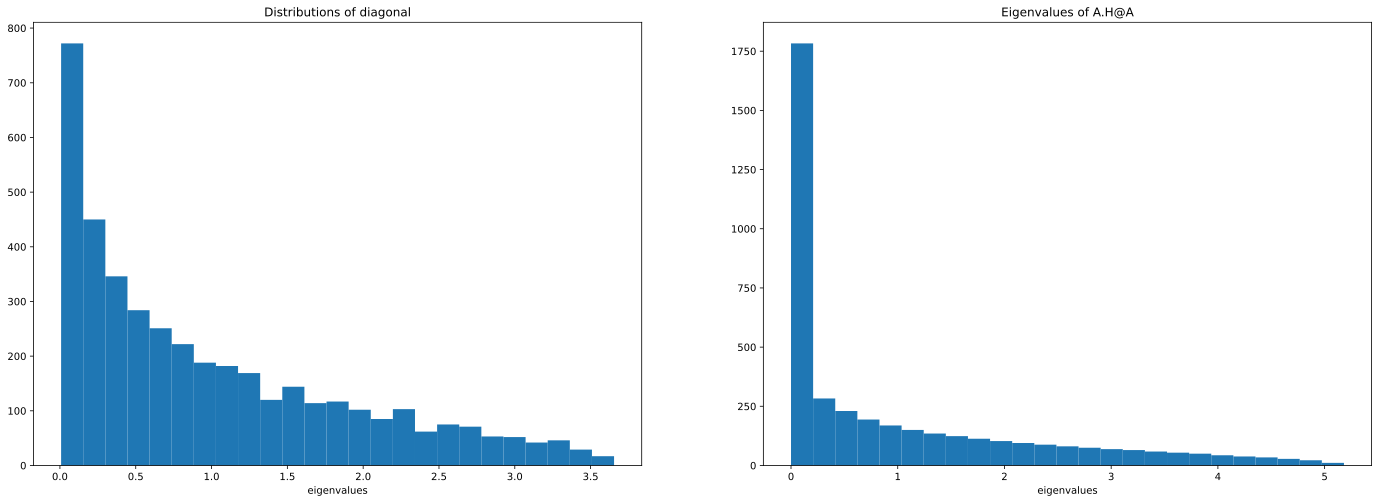

In [18]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].hist((diagonal).abs().flatten().cpu(), bins=n_bins);
ax[0].set_xlabel('eigenvalues')
ax[0].set_title('Distributions of diagonal')
ax[1].hist(eigenvalues_A.abs().flatten().cpu(), bins=n_bins);
ax[1].set_xlabel('eigenvalues')
ax[1].set_title('Eigenvalues of A.H@A')

plt.show()

# Test playground for structured random model

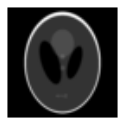

In [4]:
img_shape = (1, 1, 64, 64)
mode = ['unit','shepp-logan']

x = generate_signal(
    shape=img_shape,
    mode=mode,
    transform=None,
    phase_range=[-np.pi/2, np.pi/2],
    dtype=torch.complex64,
    device=device,
)

plot(x.angle())

In [6]:
input_size = 64
output_size = 90

physics = dinv.physics.StructuredRandomPhaseRetrieval(
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    n_layers=2,
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transforms=["fourier2","hadamard1"],
    dtype=torch.complex64,
    device=device,
)
print("physics structure:", physics.structure)

middle shape: (1, 128, 128)


physics structure: FDFD


In [32]:
delta = generate_signal(
    shape=(1, 1, 90, 90),
    mode=['delta','constant'],
    dtype=torch.complex64,
    device=device,
)

adversarial = physics.get_adversarial(n_layers=1,trimmed=True)
adversarial.shape

torch.Size([1, 1, 64, 64])

In [33]:
y_normal = physics(x)
y_adversarial = physics(adversarial*10)

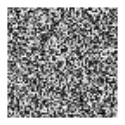

In [34]:
plot(adversarial.angle())

In [35]:
x_recon = spectral_methods(y_normal, physics, n_iter=3000)
x_adversarial_recon = spectral_methods(y_adversarial, physics, n_iter=3000)

print("cosine similarity normal:", cosine_similarity(x_recon, x))
print("cosine similarity adversarial:", cosine_similarity(x_adversarial_recon, adversarial))

cosine similarity normal: tensor(0.6139, device='cuda:3')
cosine similarity adversarial: tensor(0.2701, device='cuda:3')


# Adversarial Input

In [7]:
input_size = 64
output_size = 130

physics = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=5,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"],["unit","uniform"],["unit","uniform"],["unit","uniform"]],
    transforms=["fourier2","fourier2","fourier2","fourier2","fourier2"],
    dtype=torch.complex64,
    device=device,
)
print("physics structure:", physics.structure)

middle shape: (1, 130, 130)
physics structure: FDFDFDFDFD


In [8]:
adv_layer = 3
adver = physics.get_adversarial(n_layers=adv_layer,trimmed=True)
adver.shape

torch.Size([1, 1, 64, 64])

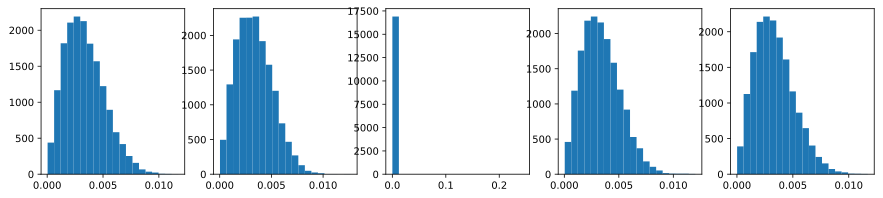

In [9]:
n_layer = physics.n_layers
# subplot showing the magnitude the measurement after every layer
fig, axes = plt.subplots(1, n_layer, figsize=(3*n_layer, 3))
for i in range(n_layer):
    axes[i].hist(physics.partial_forward(adver, i+1).abs().flatten().cpu(), bins=20)
fig.show()

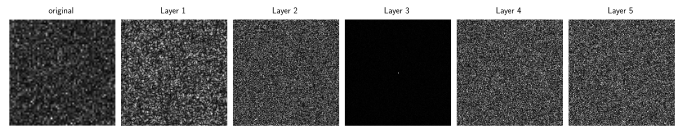

In [13]:
measurements = [adver]

for i in range(n_layer):
    measurements.append(physics.partial_forward(adver, i+1).abs())

labels = ['original']
for i in range(n_layer):
    labels.append(f"Layer {i+1}")

plot(measurements,labels,save_dir="../figures/adver_vis.pdf")

In [98]:
print(measurements[-1].abs().max())
measurements[-1]

tensor(0.2422, device='cuda:3')


tensor([[[[-0.0052+1.3709e-03j, -0.0017-3.1066e-03j,  0.0016-9.1239e-04j,
            ...,  0.0021+3.2884e-04j, -0.0004+1.0947e-03j,
           -0.0007+2.3618e-03j],
          [-0.0001-2.3501e-04j,  0.0003-2.1014e-03j, -0.0025-3.5346e-04j,
            ..., -0.0042+7.4979e-04j,  0.0007-1.9871e-04j,
            0.0027-6.5296e-04j],
          [ 0.0031+7.6722e-05j,  0.0022-3.1916e-03j, -0.0010-1.9555e-03j,
            ..., -0.0018+2.1490e-03j, -0.0007-3.5467e-03j,
            0.0012-1.8831e-03j],
          ...,
          [ 0.0004+1.0921e-03j, -0.0016-1.8432e-03j, -0.0024+2.4889e-03j,
            ...,  0.0013+5.7211e-04j, -0.0021+5.7254e-04j,
            0.0004+4.9091e-03j],
          [ 0.0031-1.1147e-03j,  0.0011+2.2490e-03j,  0.0013-2.2052e-03j,
            ..., -0.0014+4.0704e-03j,  0.0016-2.6408e-04j,
            0.0007+1.6846e-03j],
          [ 0.0005-1.1191e-03j, -0.0031+4.6528e-03j, -0.0069+2.4411e-03j,
            ..., -0.0011+1.7503e-03j,  0.0029-2.8555e-04j,
           -0.0007-2.5

cosine similarity: tensor(0.8435, device='cuda:3')


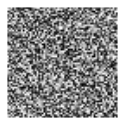

In [91]:
adver_spec = spectral_methods(physics(adver), physics, n_iter=3000)
print("cosine similarity:", cosine_similarity(adver_spec, adver))
plot(adver_spec.angle())

# Spectrum of Forward Matrix

## Oversampling unitray matrices

In [28]:
input_size = 64
output_size = 90

In [9]:
unitary = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

unitary_fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_unitary = unitary.B.get_singular_values()
s_unitary_fft_padded = unitary_fft_padded.B.get_singular_values()
s_unitary_dct_padded = unitary_dct_padded.B.get_singular_values()
s_unitary_hadamard_padded = unitary_hadamard_padded.B.get_singular_values()

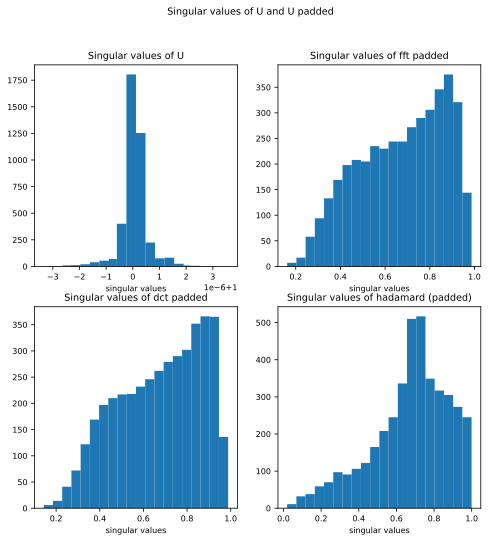

In [12]:
mpl.rcParams.update({'font.size': 8})
# two figures plotting the histogram of two spectrum
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0,0].hist(s_unitary, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values of U')
ax[0,1].hist(s_unitary_fft_padded, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values of fft padded')
ax[1,0].hist(s_unitary_dct_padded, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values of dct padded')
ax[1,1].hist(s_unitary_hadamard_padded, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values of hadamard (padded)')
fig.suptitle('Singular values of U and U padded')
plt.show()

## Oversampling Marchenko matrices, right diagonal

In [21]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

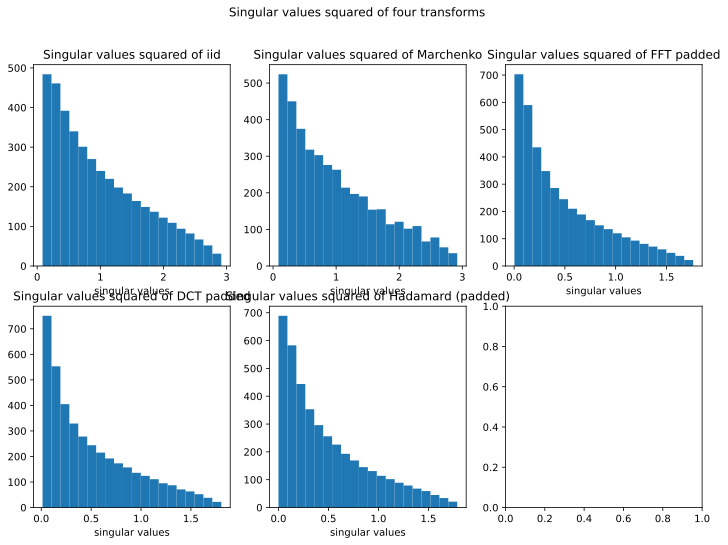

In [23]:
# plotting the histogram of the spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid**2, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Oversampling Marchenko matrices, left diagonal

In [29]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

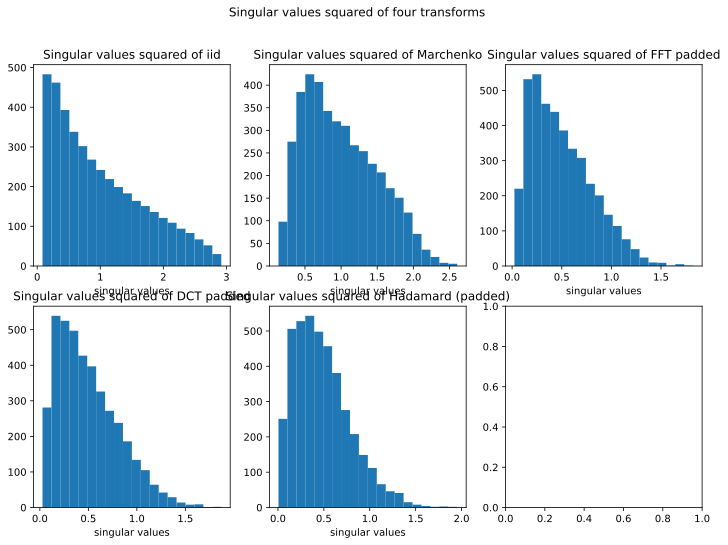

In [31]:
# plotting the histogram of the spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid**2, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Subsampling unitary matrices

In [32]:
input_size = 64
output_size = 40

In [ ]:
unitary = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

unitary_fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

unitary_hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_unitary = unitary.B.get_singular_values()
s_unitary_fft_padded = unitary_fft_padded.B.get_singular_values()
s_unitary_dct_padded = unitary_dct_padded.B.get_singular_values()
s_unitary_hadamard_padded = unitary_hadamard_padded.B.get_singular_values()

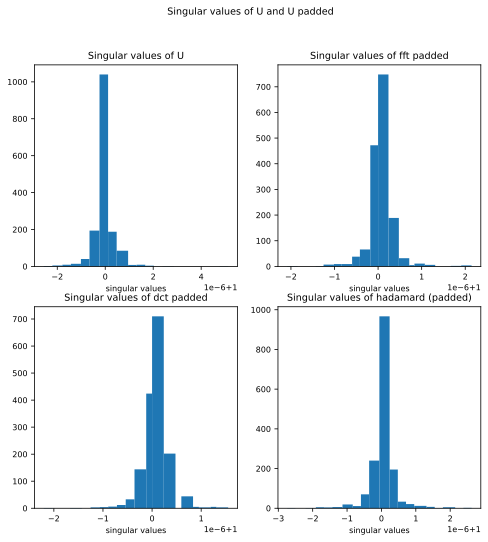

In [19]:
mpl.rcParams.update({'font.size': 8})
# two figures plotting the histogram of two spectrum
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0,0].hist(s_unitary, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values of U')
ax[0,1].hist(s_unitary_fft_padded, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values of fft padded')
ax[1,0].hist(s_unitary_dct_padded, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values of dct padded')
ax[1,1].hist(s_unitary_hadamard_padded, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values of hadamard (padded)')
fig.suptitle('Singular values of U and U padded')
plt.show()

## Subsampling Marchenko matrices, right diagonal

In [25]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

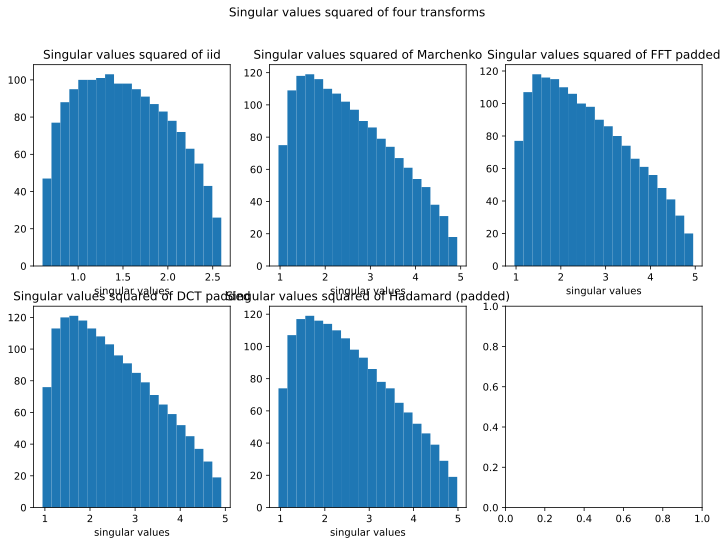

In [ ]:
# four figures plotting the histogram of four spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of FFT unpadded')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Subsampling Marchenko matrices, left diagonal

In [33]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

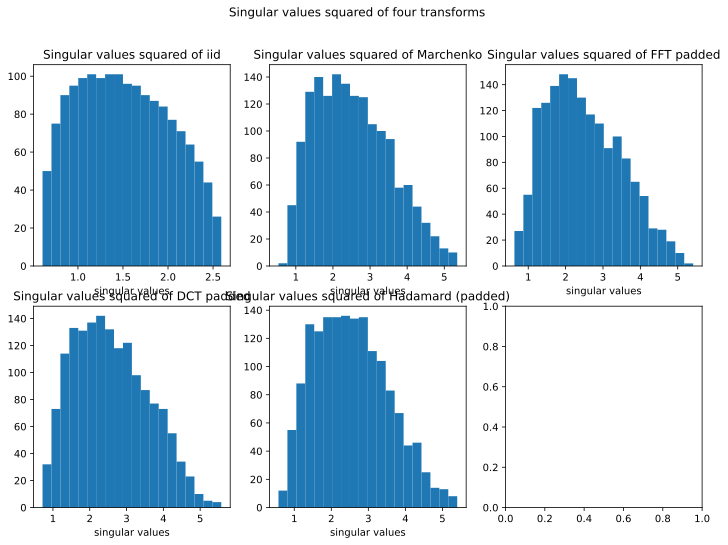

In [35]:
# four figures plotting the histogram of four spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Subsampling Marchenko matrices, using distribution for oversampling 1

In [ ]:
iid = dinv.physics.RandomPhaseRetrieval(
    m=int(output_size**2),
    img_shape=(1, input_size, input_size),
    dtype=torch.complex64,
    device=device,
)

marchenko = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=False,
)

fft_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="fft",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

dct_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="dct",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_padded = dinv.physics.StructuredRandomPhaseRetrieval(
    spectrum="unit",
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonals=[["marchenko","uniform"],["unit","uniform"]],
    transform="hadamard",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [ ]:
s_iid = sp.linalg.svdvals(iid.B._A.cpu().numpy())
s_marchenko = marchenko.B.get_singular_values()
s_fft_padded = fft_padded.B.get_singular_values()
s_dct_padded = dct_padded.B.get_singular_values()
s_hadamard_padded = hadamard_padded.B.get_singular_values()

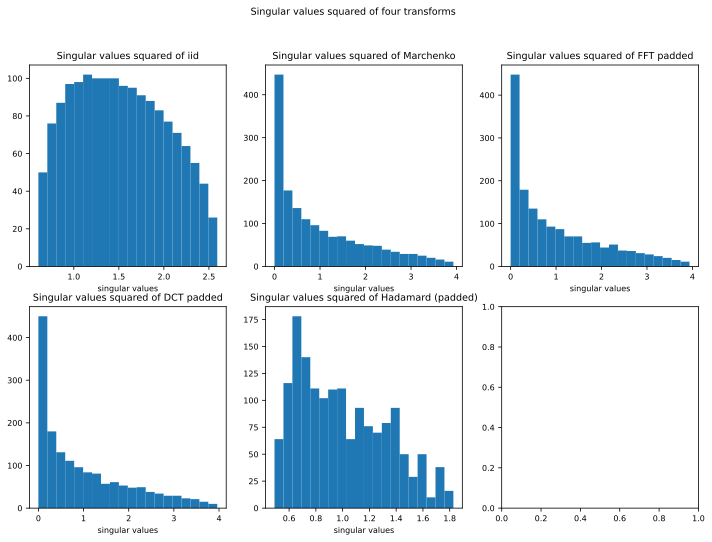

In [32]:
# four figures plotting the histogram of four spectrum
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0,0].hist(s_iid, bins=20);
ax[0,0].set_xlabel('singular values')
ax[0,0].set_title('Singular values squared of iid')
ax[0,1].hist(s_marchenko**2, bins=20);
ax[0,1].set_xlabel('singular values')
ax[0,1].set_title('Singular values squared of Marchenko')
ax[0,2].hist(s_fft_padded**2, bins=20);
ax[0,2].set_xlabel('singular values')
ax[0,2].set_title('Singular values squared of FFT padded')
ax[1,0].hist(s_dct_padded**2, bins=20);
ax[1,0].set_xlabel('singular values')
ax[1,0].set_title('Singular values squared of DCT padded')
ax[1,1].hist(s_hadamard_padded**2, bins=20);
ax[1,1].set_xlabel('singular values')
ax[1,1].set_title('Singular values squared of Hadamard (padded)')
fig.suptitle('Singular values squared of four transforms')
plt.show()

## Marchenko Hadamard oversampling close to 1

In [8]:
hadamard_1 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 62, 62),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

hadamard_2 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 66, 66),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="hadamard2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

fft_1 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 62, 62),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fourier2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

fft_2 = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, 64, 64),
    output_shape=(1, 66, 66),
    diagonals=[["unit","uniform"],["marchenko","uniform"]],
    transform="fourier2",
    dtype=torch.complex64,
    device=device,
    pad_powers_of_two=True,
)

In [9]:
s_hadamard1 = hadamard_1.get_singular_values()
s_hadamard2 = hadamard_2.get_singular_values()
s_fft1 = fft_1.get_singular_values()
s_fft2 = fft_2.get_singular_values()

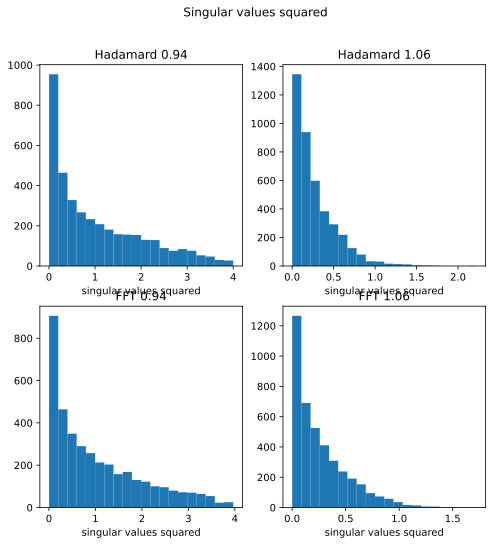

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0,0].hist(s_hadamard1**2, bins=20);
ax[0,0].set_xlabel('singular values squared')
ax[0,0].set_title('Hadamard 0.94')
ax[0,1].hist(s_hadamard2**2, bins=20);
ax[0,1].set_xlabel('singular values squared')
ax[0,1].set_title('Hadamard 1.06')
ax[1,0].hist(s_fft1**2, bins=20);
ax[1,0].set_xlabel('singular values squared')
ax[1,0].set_title('FFT 0.94')
ax[1,1].hist(s_fft2**2, bins=20);
ax[1,1].set_xlabel('singular values squared')
ax[1,1].set_title('FFT 1.06')
fig.suptitle('Singular values squared')
plt.show()

# Sample Covriance Computation

In [6]:
def compute_sample_covariance_structured_random(
    n_layers = 1,
    size = 8,
    n_samples = 1000,
    transform = "fourier2",
    device = 'cpu',
):
    """ Given a n_layers configuration, compute the sample covariance matrix of the elements of the forward matrix of the structured random model."""
    matrices = torch.empty(n_samples, size**4, dtype=torch.complex64, device=device)
    for i in range(n_samples):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            input_shape=(1, size, size),
            output_shape=(1, size, size),
            n_layers=n_layers,
            diagonals=[["unit","uniform"]] * int(np.floor(n_layers)),
            transforms=[transform] * int(np.ceil(n_layers)),
            dtype=torch.complex64,
            device=device,
        )
        matrices[i] = physics.get_forward_matrix().flatten()
    # sample mean
    mean = matrices.mean(dim=0)
    # sample covariance
    covariance = torch.einsum('ij,ik->jk', matrices-mean, (matrices-mean).conj())/(n_samples-1)
    return covariance

In [7]:
def compute_sample_covariance_circulant(
    size,
    n_samples = 1000,
    device = 'cpu'
):
    """ Compute the sample covariance matrix of the elements of the left circulant matrix."""
    matrices = torch.empty(n_samples, size**2, dtype=torch.complex64, device=device)
    for i in range(n_samples):
        row = torch.randn(size, device=device)
        matrix = torch.zeros((size, size))
        for j in range(size):
            # Shift vector left by i positions
            shifted = torch.roll(row, shifts=-j)
            matrix[j] = shifted
        matrices[i] = matrix.flatten()
    # sample mean
    mean = matrices.mean(dim=0)
    # sample covariance
    covariance = torch.einsum('ij,ik->jk', matrices-mean, (matrices-mean).conj())/(n_samples-1)
    return covariance

In [29]:
size = 8
n_samples = 10000

In [13]:
covariance_1_fourier = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1_cosine = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1_hadamard = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="hadamard2", device=device)

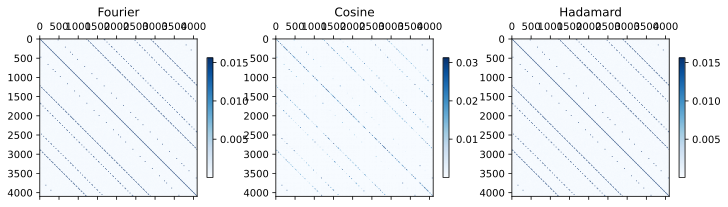

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_1_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_1_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_1_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.show()

In [15]:
covariance_1p5_fourier = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1p5_cosine = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1p5_hadamard = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="hadamard2", device=device)
covariance_circulant = compute_sample_covariance_circulant(size=size**2, n_samples=n_samples, device=device)

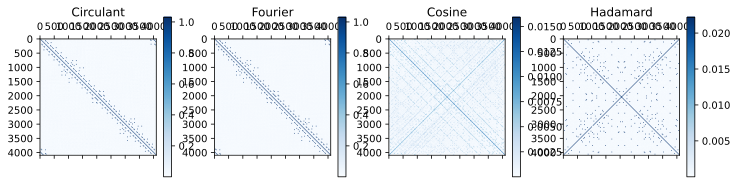

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(12,48))
im1 = axes[0].matshow(covariance_circulant.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Circulant")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_1p5_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Fourier")
fig.colorbar(im1, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_1p5_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Cosine")
fig.colorbar(im2, ax=axes[2], shrink=0.06)
im4 = axes[3].matshow(covariance_1p5_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[3].set_title("Hadamard")
fig.colorbar(im3, ax=axes[3], shrink=0.06)
plt.show()

In [30]:
covariance_2_fourier = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_2_cosine = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_2_hadamard = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="hadamard2", device=device)

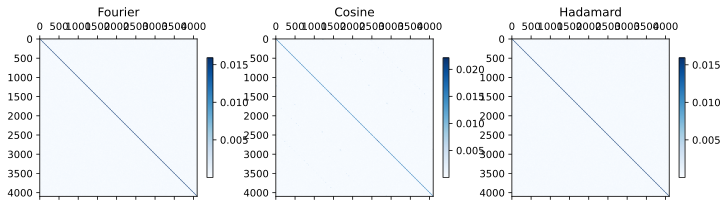

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_2_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_2_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_2_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.show()

In [38]:
covar = covariance_2_cosine.abs()
print(covar.diagonal().min())
for i in range(covar.shape[0]):
    covar[i,i] = 0
print(covar.max())

tensor(0.0091, device='cuda:0')
tensor(0.0109, device='cuda:0')


In [22]:
size = 2
n_samples = 10000

In [23]:
covariance_1_fourier = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1_cosine = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1_hadamard = compute_sample_covariance_structured_random(n_layers=1, size=size, n_samples=n_samples, transform="hadamard2", device=device)

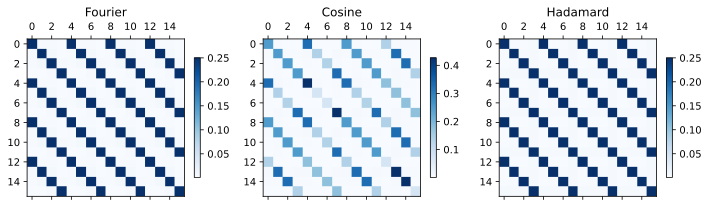

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_1_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_1_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_1_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.show()

In [25]:
covariance_1p5_fourier = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_1p5_cosine = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_1p5_hadamard = compute_sample_covariance_structured_random(n_layers=1.5, size=size, n_samples=n_samples, transform="hadamard2", device=device)
covariance_circulant = compute_sample_covariance_circulant(size=size**2, n_samples=n_samples, device=device)

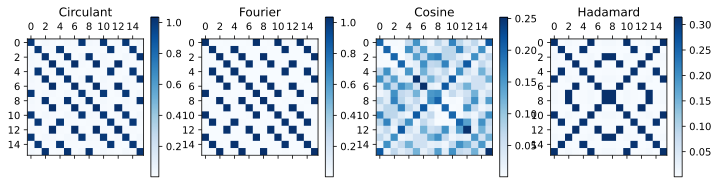

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(12,48))
im1 = axes[0].matshow(covariance_circulant.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Circulant")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_1p5_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Fourier")
fig.colorbar(im1, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_1p5_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Cosine")
fig.colorbar(im2, ax=axes[2], shrink=0.06)
im4 = axes[3].matshow(covariance_1p5_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[3].set_title("Hadamard")
fig.colorbar(im3, ax=axes[3], shrink=0.06)
plt.show()

In [27]:
covariance_2_fourier = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="fourier2", device=device)
covariance_2_cosine = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="cosine2", device=device)
covariance_2_hadamard = compute_sample_covariance_structured_random(n_layers=2, size=size, n_samples=n_samples, transform="hadamard2", device=device)

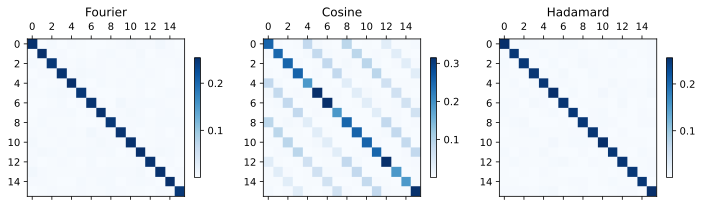

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12,36))
im1 = axes[0].matshow(covariance_2_fourier.abs().cpu(),cmap=plt.cm.Blues)
axes[0].set_title("Fourier")
fig.colorbar(im1, ax=axes[0], shrink=0.06)
im2 = axes[1].matshow(covariance_2_cosine.abs().cpu(),cmap=plt.cm.Blues)
axes[1].set_title("Cosine")
fig.colorbar(im2, ax=axes[1], shrink=0.06)
im3 = axes[2].matshow(covariance_2_hadamard.abs().cpu(),cmap=plt.cm.Blues)
axes[2].set_title("Hadamard")
fig.colorbar(im3, ax=axes[2], shrink=0.06)
plt.show()